# Movies Data Project

## Miri Hazanov, Alon Maharshak

### First step-collect and preapre the data



#### During this project we will work with the "Cornell Movie-Dialogs Corpus" created by the Cornell University

Our first step is to understand the data.

* Import the relevent Packeges 
* Open the movie titles files and the movie lines file.

In [127]:
import pandas as pd
import nltk
import re
import string 

fileName='C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/movie_lines.txt'
with open(fileName) as f:
    lines = f.readlines()
fileName='C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/movie_titles_metadata.txt'
with open(fileName) as f:
    titles = f.readlines()

Now lets print an exapmle so we can see how our meta data and raw data looks like

In [128]:
print(titles[0])
print(lines[0])

m0 +++$+++ 10 things i hate about you +++$+++ 1999 +++$+++ 6.90 +++$+++ 62847 +++$+++ ['comedy', 'romance']

L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!



As we can see, the data has a '+++$+++' seperator, so now we can start work on the data.

Our stages we'll be:
* Create a list of each genre using the generes list in the titles file
* Get the title with the most lines in each genre so well have a lot of lines to work with
* Clean the data, getting only the movie line after cleaning of lower case and other unnecessary marks.
* Create a csv file with the Line, movie name and movie genre.

The reason we are using the Genere factor is because we want the movies to have big diffrences in style, so we can better train the model later.

### Create list function:
returns a list of all the movie id's that are relevent to a selected genre.

In [129]:
def createList(genre):
    ans=[]
    for title in titles:
        att=title.split('+++$+++')
        if genre in att[5]:
            ans.append(att[0])
    return ans

### Get the movie with the most lines function

In [130]:
def getMaxLines(movielist):
    x=0
    maxMovie=''
    for movie in movielist:
        movieline='+++$+++ '+movie+'+++$+++'
        movieLines=[line for line in lines if movieline in line]
        if len(movieLines)>x:
            x=len(movieLines)
            maxMovie=movie
    return maxMovie

### Clean the movie data function

* takes the raw line, strips only the movie line.
* remove from the movie line unnecessary marks and swtich to lower case 
* strip the movie name 
* Check the parameter K, that tells you how many sentences you want to put together

Returns a tuple of the movie name + a list of all the movie lines(clean)

In [131]:
def cleanMovie(movie,k):
    num=int(movie[1:])
    movieLinesRaw=[line for line in lines if '+++$+++ '+ movie+'+++$+++' in line]
    MovieLinesClean=[]
    results=[]
    for line in movieLinesRaw:
         att=line.split('+++$+++')
         MovieLinesClean.append(att[4])
    returnLines=[]
    att=titles[num].split('+++$+++')
    results.append(att[1])
    for line in MovieLinesClean:
        line=line.lower()
        for char in string.punctuation:
            if char!="'":
                line = line.replace(char, ' ')
        line=' '.join(line.split())
        returnLines.append(line)
    
    new_results=[]
    if k>1:
        for i in range(len(returnLines)-1):
            line=''
            if i%k==0:
                line=returnLines[i]+' '+returnLines[i+1]
                new_results.append(line)
        results.append(new_results)
    else:
        results.append(returnLines)
    return results

### Create CSV files function:

In [132]:
def makeCsv(movie,name,genre):
    df=pd.DataFrame()
    df['lines']=movie
    df['name']=name
    return df

### Now we can activate all of the stages for all the 3 movies and concatene them into one csv file:

In [133]:
def makeDB(k):
    adventureList=createList('adventure') 
    dramaList=createList('drama') 
    comedyList=createList('comedy') 

    maxAdventure=getMaxLines(adventureList)
    maxDrama=getMaxLines(dramaList)
    maxComedy=getMaxLines(comedyList)

    movieDrama=cleanMovie(maxDrama,k)
    movieComedy=cleanMovie(maxComedy,k)
    movieAdventure=cleanMovie(maxAdventure,k)

    dramaDf=makeCsv(movieDrama[1],movieDrama[0],'Drama')
    comedyDf=makeCsv(movieComedy[1],movieComedy[0],'Comedy')
    AdventureDf=makeCsv(movieAdventure[1],movieAdventure[0],'Adventure')
    result = pd.concat([dramaDf,comedyDf,AdventureDf])
    result.to_csv('C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/MoviesLines'+str(k)+'.csv')
    return result

## Second part of the project:
### building calssification Model

In this part we will take the list of movie lines that we collected earlier and try to build a classification model out of it.

First we'll need to transform the vocabulary of words into features- we'll use the Bag of words technique.
We'll use the CountVectorizer package and use a "word" analyzer to get maximun features for our model.
We'll try to play with the K parameters and see when do we get the best results.

## createModels

In this function we get the movie lines as a parameter and create diffrent models, returning the result.
* We divide the set into train and test
* we create each model, fit and score.

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm 
from sklearn import neighbors 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold
def createModels(result):
    np.random.seed(123)
    x = np.random.rand(len(result['lines'])) < 0.8
    train_x = train_data_features[x]
    test_x = train_data_features[~x]
    train_y = result.loc[x,"name"]
    test_y = result.loc[~x,"name"]

    forest = RandomForestClassifier(n_estimators = 100) 
    model = forest.fit( train_x, train_y )
    forestScore=model.score(test_x,test_y)
    print("RandomForestClassifier: {}".format(forestScore))

    knn = neighbors.KNeighborsClassifier(3) 
    model=knn.fit(train_x, train_y) 
    knnScore = model.score(test_x,test_y) 
    print("knn: {}".format(knnScore))

    svml = svm.LinearSVC() 
    model=svml.fit(train_x, train_y) 
    svmScore=model.score(test_x,test_y)
    print("svm: {}".format(svmScore))

    tree = DecisionTreeClassifier()
    model = tree.fit( train_x, train_y )
    treeScore=model.score(test_x,test_y)
    print("DecisionTreeClassifier: {}".format(treeScore))

    Reg = LogisticRegression()
    model = Reg.fit( train_x, train_y )
    RegScore=model.score(test_x,test_y)
    print("LogisticRegression: {}".format(RegScore))
    data=[knnScore,forestScore,svmScore,treeScore,RegScore]
    return data

### Visualization:

Thiss function gets all of the models scores and create a bar graph so we can see which model is best

In [135]:
def createPlot(data):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    ax.set_ylabel('Scores')
    plt.xlabel('Model')
    ax.set_title('Scores by model')
    index = np.arange(5)
    plt.bar(index,data,alpha=0.4, color='r',label='Model')
    ax.set_xticklabels(('G1', 'KNN', 'RandomForest', 'SVM', 'DecisionTree','LogisticReg'))
    plt.tight_layout()
    plt.show()

## Build the Model:
### Main program

After we created all the function that we need we'll do the following steps.
1. create a data set, each time using a difftrent K(how many sentences do we want to put together)
2. Create the BOW with 5000 features
3. Create the models and return the scores for each one.
4. Plot the scores and see which model is the best.

(3997L, 2886L)
RandomForestClassifier: 0.632627646326
knn: 0.488169364882
svm: 0.673723536737
DecisionTreeClassifier: 0.552926525529
LogisticRegression: 0.678704856787


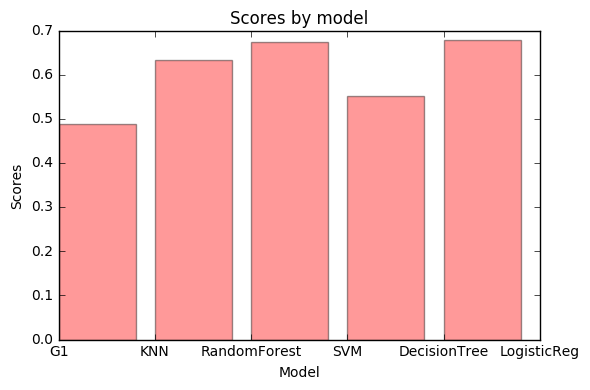

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
result=makeDB(1)
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
train_data_features = vectorizer.fit_transform(result['lines'])
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
print(train_data_features.shape)
data=createModels(result)
createPlot(data)

### We can see that when we address each sentence separately the highest score is 67.8% with the Logisitc Regression model.

Now let's see what happen when we increase our K.

### We'll run a loop from 2 to 5, and see which K gives us the best reuslts

(1998L, 2886L)
RandomForestClassifier: 0.653937947494
knn: 0.513126491647
svm: 0.73031026253
DecisionTreeClassifier: 0.546539379475
LogisticRegression: 0.747016706444


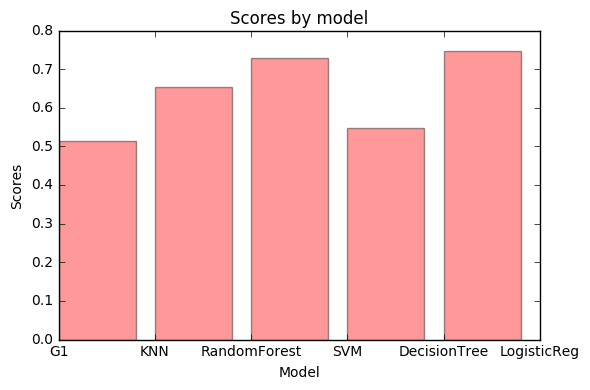

(1332L, 2384L)
RandomForestClassifier: 0.661654135338
knn: 0.481203007519
svm: 0.676691729323
DecisionTreeClassifier: 0.59022556391
LogisticRegression: 0.721804511278


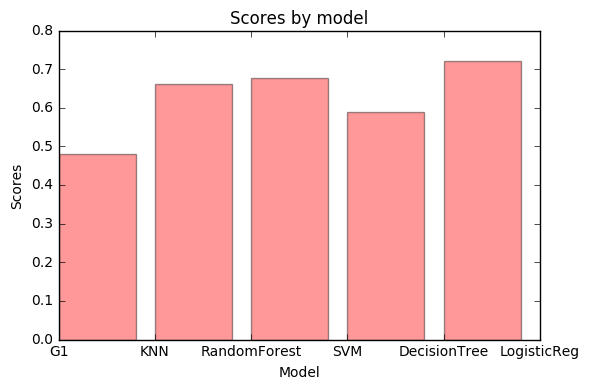

(1000L, 1980L)
RandomForestClassifier: 0.717171717172
knn: 0.525252525253
svm: 0.69696969697
DecisionTreeClassifier: 0.550505050505
LogisticRegression: 0.752525252525


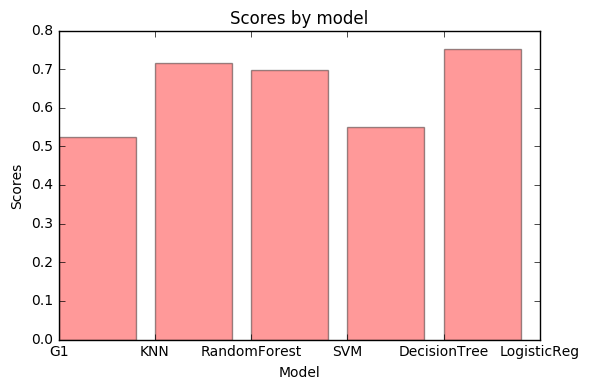

(800L, 1780L)
RandomForestClassifier: 0.602409638554
knn: 0.475903614458
svm: 0.668674698795
DecisionTreeClassifier: 0.512048192771
LogisticRegression: 0.674698795181


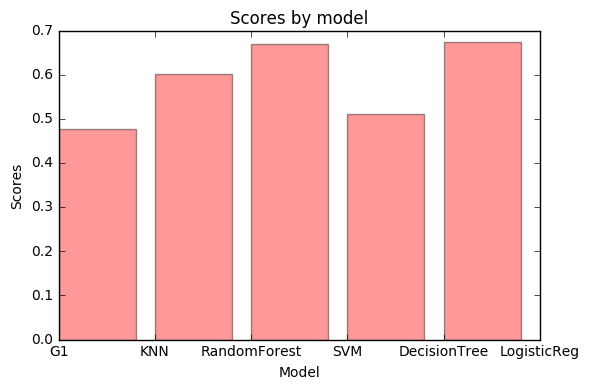

In [14]:
for i in range(2,6):
    result=makeDB(i)
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
    train_data_features = vectorizer.fit_transform(result['lines'])
    train_data_features = train_data_features.toarray()
    vocab = vectorizer.get_feature_names()
    dist = np.sum(train_data_features, axis=0)
    print(train_data_features.shape)
    data=createModels(result)
    createPlot(data)

## Results:

1. AS we can see The scores were better with higher K until we reached the value of 5. 
2. In all of our model, Logistic regression was the best fit.
3. the best score was 75.5% that was achived when K=4.

## Third and Forth part of the project:
### building kares Model for generate sentences

In [140]:
import numpy as np
import theano
import keras
import pandas as pd
import random

In [141]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence

### After we finished importing all the data we can start preparing it.

## Create a model function
 We created a function that gets the movie text and create a squential nuernal network using embedding technique.
 
 We turn the text into word matrix, compile and fit the model.

In [151]:
def makeModel(movie):
    text2 = text_to_word_sequence(movie, lower=False, split=" ") #using only 10000 first words
    token = Tokenizer(nb_words=2000,char_level=False)
    token.fit_on_texts(text2)
    text_mtx = token.texts_to_matrix(text2, mode='binary')

    text_mtx.shape

    input_ = text_mtx[:-1]
    output_ = text_mtx[1:]
    input_.shape, output_.shape

    model = Sequential()
    model.add(Embedding(input_dim=input_.shape[1],output_dim= 42, input_length=input_.shape[1]))
    model.add(Flatten())
    model.add(Dense(output_.shape[1], activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=["accuracy"])
    model.fit(input_, y=output_, batch_size=300, nb_epoch=7, verbose=1, validation_split=0.2)
    return model

## get next word function

We'll create a function thet gets the word metrix and randommaly select a word from it in order to create a new sentence.

In [206]:
def get_next(text,token,model,fullmtx,fullText):
    tmp = text_to_word_sequence(text, lower=False, split=" ")
    tmp = token.texts_to_matrix(tmp, mode='binary')
    p = model.predict(tmp)
    x= np.random.random_sample()*1000
    return fullText[int(x)]

## Create new sentence.

According to the movie text and the relevenat model for each movie, we're creating new sentences.

1) total of 350 sentences for each movie.
2) Length of sentence is between 2 and 12 word.

In [208]:
def createSentences(model,movie):
    text2 = text_to_word_sequence(movie, lower=False, split=" ") #using only 10000 first words
    token = Tokenizer(nb_words=2000,char_level=False)
    token.fit_on_texts(text2)
    text_mtx = token.texts_to_matrix(text2, mode='binary')
    text_mtx.shape
    word="b"
    newLine=[]
    for j in range(0,350):
        y=""
        k=int(random.random()*10+2)
        for i in range(0,k):
            word=get_next(word,token,model,text_mtx,text2)
            y=y+' '+word
        newLine.append(y)
    
    return newLine


## Make it happen.

Now we use the function that we created in order to:
1) create one string for each movie
2) create 3 models of each movie
3) create new sentences for each movie and make them into a list

In [152]:
lines=pd.read_csv("C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/MoviesLines2.csv")
lines1=lines[lines.name == ' casino ']
lines2=lines[lines.name == ' chill factor ']
lines3=lines[lines.name == ' innerspace ']
text1=lines1["lines"]
text2=lines2["lines"]
text3=lines3["lines"]

movie1=' '.join(line for line in text1)
movie2=' '.join(line for line in text2)
movie3=' '.join(line for line in text3)

model1=makeModel(movie1)
model2=makeModel(movie2)
model3=makeModel(movie3)

newLines1=createSentences(model1,movie1)
newLines2=createSentences(model2,movie2)
newLines3=createSentences(model3,movie3)


Train on 13478 samples, validate on 3370 samples
Epoch 1/7
13478/13478 [==============================] - 321s - loss: 6.4801 - acc: 0.0146 - val_loss: 6.2197 - val_acc: 0.0145
Epoch 2/7
13478/13478 [==============================] - 319s - loss: 6.0435 - acc: 0.0174 - val_loss: 6.2399 - val_acc: 0.0582
Epoch 3/7
13478/13478 [==============================] - 319s - loss: 5.9135 - acc: 0.0507 - val_loss: 6.2828 - val_acc: 0.0582
Epoch 4/7
13478/13478 [==============================] - 319s - loss: 5.7432 - acc: 0.0507 - val_loss: 6.0929 - val_acc: 0.0582
Epoch 5/7
13478/13478 [==============================] - 319s - loss: 5.5315 - acc: 0.0507 - val_loss: 6.0181 - val_acc: 0.0608
Epoch 6/7
13478/13478 [==============================] - 320s - loss: 5.2741 - acc: 0.0881 - val_loss: 5.8455 - val_acc: 0.0994
Epoch 7/7
13478/13478 [==============================] - 320s - loss: 5.0126 - acc: 0.1134 - val_loss: 5.8379 - val_acc: 0.1083
Train on 5605 samples, validate on 1402 samples
Epoch 1

KeyError: 1691L

## Create CSV's 

Next steps:

1) create csv for each new lines list
2) concat all of them into one file in order to classify them

In [221]:
df1 = pd.DataFrame(np.array(newLines1))
df1.to_csv('C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/newLines1.csv')
df2= pd.DataFrame(np.array(newLines2))
df2.to_csv('C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/newLines2.csv')
df3= pd.DataFrame(np.array(newLines3))
df3.to_csv('C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/newLines3.csv')
result = pd.concat([df1,df2,df3])
result.to_csv('C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/newLines.csv')

## Final step - classiffy

Like before

1) Read the new Lines
2) creare data features
3) train the data on the models. 
4) Plot the results

(1050L, 726L)
RandomForestClassifier: 0.73786407767
knn: 0.587378640777
svm: 0.820388349515
DecisionTreeClassifier: 0.650485436893
LogisticRegression: 0.839805825243


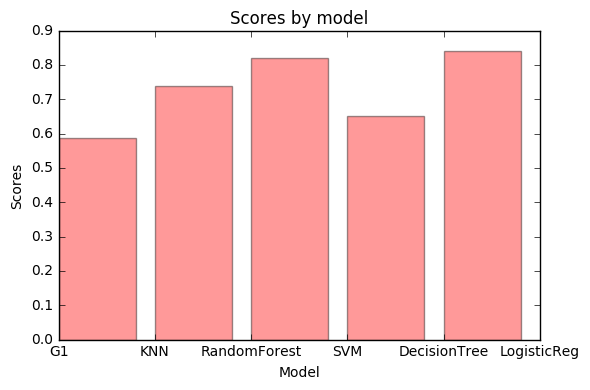

In [224]:
np.random.seed(123)
result=pd.read_csv("C:/Users/Lior/Desktop/FinalProject-master/FinalProject-master/newLines.csv")
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,preprocessor = None,stop_words = None,max_features = 5000)
train_data_features = vectorizer.fit_transform(result['lines'])
train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
print(train_data_features.shape)
data=createModels(result)
createPlot(data)

# Results:

** We can see that with the Logistic regressing we got a 0.84 results and 0.82 with svm. **